# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

`1.1` Check **user-item-interactions** dataset:

In [3]:
df.shape

(45993, 3)

In [4]:
df.dtypes

article_id    float64
title          object
email          object
dtype: object

In [5]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [6]:
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

`1.2` Create **article ditribution** dataset:

In [7]:
article_dist = df.groupby('email')['article_id'].count()
article_dist.head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

In [8]:
article_dist.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

`1.3` Plot distribution:

Text(0,0.5,'count of such cases')

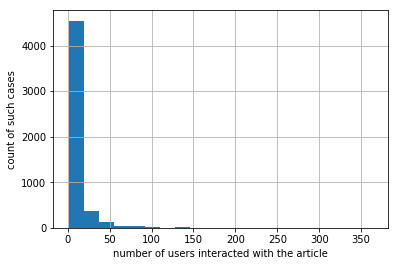

In [9]:
plt.figure()
article_dist.hist(bins=20)
plt.xlabel("number of users interacted with the article")
plt.ylabel("count of such cases")

In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = article_dist.median()
print(median_val)
max_views_by_user = article_dist.max()
print(max_views_by_user)

3.0
364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles
df_content.head()
article_dupl = df_content['article_id'].value_counts()
article_dupl.describe()

count    1051.000000
mean        1.004757
std         0.068842
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: article_id, dtype: float64

In [12]:
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [13]:
# show duplicates
article_dupl[article_dupl>1]

221    2
232    2
577    2
398    2
50     2
Name: article_id, dtype: int64

In [14]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')

In [15]:
df_content.nunique()

doc_body           1031
doc_description    1019
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [16]:
df['article_id'].nunique()

714

In [17]:
df['article_id'][~(df['email'].isnull())].nunique()

714

In [18]:
df['email'].nunique()

5148

In [19]:
df_content['article_id'].nunique()

1051

In [20]:
df.shape[0]

45993

In [21]:
unique_articles = df['article_id'][~(df['email'].isnull())].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0]  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
article_count = df.groupby('article_id')['email'].count()
article_count.head()

article_id
0.0    14
2.0    58
4.0    13
8.0    85
9.0    10
Name: email, dtype: int64

In [23]:
max_article_count = article_count.max()
print(max_article_count)

937


In [24]:
max_article_id = str(article_count[article_count == max_article_count].index[0])
print(max_article_id)

1429.0


In [25]:
most_viewed_article_id = max_article_id # The most viewed article in the dataset as a string with one value following the decimal 
max_views = max_article_count# The most viewed article in the dataset was viewed how many times?

In [26]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [27]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [28]:
article_inter = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)

temp = article_inter.head(5).index.tolist()
temp



[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

In [29]:
df_out = df[df['article_id'].isin(temp)]
df_out['title']

2               use deep learning for image classification
6               use deep learning for image classification
29       predicting churn with the spss random tree alg...
37                          visualize car data with brunel
41              use deep learning for image classification
42       use xgboost, scikit-learn & ibm watson machine...
45                          visualize car data with brunel
53       use xgboost, scikit-learn & ibm watson machine...
60       use xgboost, scikit-learn & ibm watson machine...
61       use xgboost, scikit-learn & ibm watson machine...
66             insights from new york car accident reports
68       use xgboost, scikit-learn & ibm watson machine...
75              use deep learning for image classification
80              use deep learning for image classification
87             insights from new york car accident reports
90       use xgboost, scikit-learn & ibm watson machine...
92       predicting churn with the spss random tree alg.

In [30]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # first find top articles
    article_inter = df.groupby('title')['user_id'].count().sort_values(ascending=False)

    top_articles = article_inter.head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_id = (pd.DataFrame(df.groupby('article_id').count()['title']).sort_values('title', ascending=False).reset_index().head(n))["article_id"]
    
    top_articles = df.article_id[df['article_id'].isin(article_id)].unique().tolist()
    top_articles_str = [str(x) for x in top_articles]
 
    return top_articles_str # Return the top article ids

In [31]:
print(get_top_articles(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


In [32]:
print(get_top_article_ids(10))

['1314.0', '1429.0', '1170.0', '1364.0', '1162.0', '1431.0', '1427.0', '1304.0', '1330.0', '1293.0']


In [33]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [34]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
5,1432.0,visualize data with the matplotlib library,6
6,1429.0,use deep learning for image classification,7
7,593.0,upload files to ibm data science experience us...,8
8,1314.0,healthcare python streaming application demo,9
9,1185.0,classify tumors with machine learning,10


In [35]:
df_temp = df[['user_id', 'article_id']]

In [36]:
df_temp['flag'] = 1

In [37]:
df_temp

,user_id,article_id,flag
0,1,1430.0,1
1,2,1314.0,1
2,3,1429.0,1
3,4,1338.0,1
4,5,1276.0,1
5,6,1432.0,1
6,7,1429.0,1
7,8,593.0,1
8,9,1314.0,1
9,10,1185.0,1


In [38]:
user_item = df_temp.groupby(['user_id', 'article_id'])['flag'].first().unstack()
user_item = user_item.fillna(0)

In [39]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_temp = df[['user_id', 'article_id']]
    df_temp['flag'] = 1
    
    user_item = df_temp.groupby(['user_id', 'article_id'])['flag'].first().unstack()
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [40]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [41]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_user = user_item.loc[user_id].dot(np.transpose(user_item))
    
    # sort by similarity
    similarity_user = similarity_user.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = similarity_user.index.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [42]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [43]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_ids_str = [float(g) for g in article_ids]
    article_names = df['title'][df['article_id'].isin(article_ids_str)].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id, :]
    article_ids = [str(article_id) for article_id in article_ids[article_ids == 1].index]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # find all seen articles by the user
    user_article_id = set(get_user_articles(user_id)[0])
    
    #get all similar users, sorted    
    similar_users = find_similar_users(user_id)
    
    # loop through the users based on the closeness
    article_diff = user_article_id.copy()
    recs = []
    
    for user in similar_users:
        
        neighbor_article_id = set(get_user_articles(user)[0])
        
        # new articles
        recs.extend(neighbor_article_id.difference(article_diff))
        article_delta = article_diff.union(neighbor_article_id)
               
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [44]:
article_ids = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
new_article_ids = [float(g) for g in article_ids]

In [45]:
df['article_id']

0        1430.0
1        1314.0
2        1429.0
3        1338.0
4        1276.0
5        1432.0
6        1429.0
7         593.0
8        1314.0
9        1185.0
10        993.0
11         14.0
12       1395.0
13       1314.0
14       1170.0
15        542.0
16         12.0
17       1430.0
18       1338.0
19        173.0
20       1314.0
21       1338.0
22       1320.0
23       1052.0
24       1432.0
25       1393.0
26       1338.0
27        593.0
28        362.0
29       1364.0
          ...  
45963    1360.0
45964     291.0
45965    1430.0
45966    1400.0
45967     495.0
45968     202.0
45969    1400.0
45970     485.0
45971    1400.0
45972     588.0
45973    1398.0
45974     270.0
45975    1165.0
45976      20.0
45977    1305.0
45978     962.0
45979     962.0
45980     138.0
45981    1324.0
45982    1324.0
45983    1157.0
45984    1416.0
45985    1394.0
45986    1125.0
45987    1282.0
45988    1324.0
45989     142.0
45990     233.0
45991    1160.0
45992      16.0
Name: article_id, Length

In [46]:
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

['healthcare python streaming application demo',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for naive bayes model',
 'use r dataframes & ibm watson natural language understanding',
 'build a python app on the streaming analytics service',
 'using deep learning to reconstruct high-resolution audio']

In [47]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."

In [48]:
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."

In [49]:
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])


In [50]:
a = set(get_user_articles(20)[0])
print(a)
b = set(['1320.0', '232.0', '844.0'])
print(b)
a == b

{'1320.0', '844.0', '232.0'}
{'1320.0', '844.0', '232.0'}


True

In [51]:
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])


In [52]:
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])


In [53]:
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])

In [54]:
user_user_recs(1,10)

['812.0',
 '1159.0',
 '1338.0',
 '1360.0',
 '1162.0',
 '337.0',
 '33.0',
 '1171.0',
 '1164.0',
 '367.0']

In [55]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['ml optimization using cognitive assistant',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'pixieapp for outlier detection',
 'apache spark lab, part 2: querying data',
 'using brunel in ipython/jupyter notebooks',
 'machine learning exercises in python, part 1',
 'visualising data the node.js way',
 'generalization in deep learning',
 'analyze facebook data using ibm watson and watson studio']

In [56]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [57]:
user_id = 20

In [58]:
similarity_user = user_item.loc[user_id].dot(np.transpose(user_item))
similarity_user.head()


user_id
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: 20, dtype: float64

In [59]:
similarity = pd.DataFrame(similarity_user).reset_index()
similarity.head(21)

,user_id,20
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


In [60]:
similarity = pd.DataFrame(similarity_user).reset_index().rename(columns={user_id:'similarity'})
similarity.head(21)

,user_id,similarity
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


In [61]:
interaction = pd.DataFrame(df.groupby('user_id')['article_id'].count()).reset_index().rename(columns={'article_id':'num_interactions'})
interaction.head(21)

,user_id,num_interactions
0,1,47
1,2,6
2,3,82
3,4,45
4,5,5
5,6,19
6,7,4
7,8,82
8,9,32
9,10,22


In [62]:
neighbors_df = pd.merge(similarity, interaction, how='left', on='user_id')
neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
neighbors_df.head()

,user_id,similarity,num_interactions
19,20,3.0,3
169,170,2.0,116
3168,3169,2.0,114
203,204,2.0,97
5137,5138,2.0,95


In [63]:
neighbors_df_remove_self = neighbors_df.drop(index=user_id-1)
neighbors_df_remove_self.head()

,user_id,similarity,num_interactions
169,170,2.0,116
3168,3169,2.0,114
203,204,2.0,97
5137,5138,2.0,95
39,40,2.0,78


In [64]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    similarity_user = user_item.loc[user_id].dot(np.transpose(user_item))
    similarity = pd.DataFrame(similarity_user).reset_index()
    similarity = pd.DataFrame(similarity_user).reset_index().rename(columns={user_id:'similarity'})
    
    interaction = pd.DataFrame(df.groupby('user_id')['article_id'].count()).reset_index().rename(columns={'article_id':'num_interactions'})
    
    neighbors_df = pd.merge(similarity, interaction, how='left', on='user_id').rename(columns={'user_id':'neighbor_id'})
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    #remove self user
    neighbors_df = neighbors_df.drop(index=user_id-1)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    similar_users = find_similar_users(user_id)
    
    user_article_id = set(get_user_articles(user_id)[0])
    article_diff = user_article_id.copy()
    recs = []
    sorted_articles = []
    
    for user in similar_users:
        neighbor_article_id = set(get_user_articles(user)[0])
            
        recs.extend(neighbor_article_id.difference(article_diff))
            
        article_diff = article_diff.union(neighbor_article_id)
            
        count = len(recs)
        
        if len(recs) >= m:    
            break
    
    neighbor_article_id = set(get_user_articles(user)[0])
            
    for article_id in neighbor_article_id:
        sorted_articles.append([article_id, get_top_article_ids(df.shape[0])])
    
    recs = recs[:count]
    
    sorted_articles.sort(key = lambda x : x[1], reverse = True)

    recs.extend([last_recs[0] for last_recs in sorted_articles[: m-count]])
                
    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]

In [65]:
get_top_sorted_users(20)

,neighbor_id,similarity,num_interactions
169,170,2.0,116
3168,3169,2.0,114
203,204,2.0,97
5137,5138,2.0,95
39,40,2.0,78
4931,4932,2.0,76
112,113,2.0,68
4882,4883,2.0,67
418,419,2.0,16
195,196,2.0,15


In [66]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1357.0', '939.0', '1154.0', '1338.0', '1360.0', '482.0', '903.0', '109.0', '1386.0', '1397.0']

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'classify tumors with machine learning', 'housing (2015): united states demographic measures', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [67]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0, 0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9, 0]# Find the 10th most similar user to user 131
print(user1_most_sim, user131_10th_sim)

3933 242


In [68]:
get_top_sorted_users(1)

,neighbor_id,similarity,num_interactions
3932,3933,35.0,45
22,23,17.0,364
3781,3782,17.0,363
202,203,15.0,160
4458,4459,15.0,158
130,131,14.0,145
3869,3870,14.0,144
45,46,13.0,63
4200,4201,13.0,61
48,49,12.0,147


In [69]:
user1_most_sim

3933

In [70]:
user131_10th_sim

242

In [71]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim
}
sol_5_dict

{'The user that is most similar to user 1.': 3933,
 'The user that is the 10th most similar to user 131': 242}

In [72]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.** <br> When we have a new user, also know as a cold start problem, there are no interactions between this new user and all other users, therefore we cannot use "most similar to other users" approach. <br> But instead, we could use something much more simpler and just recommend most "rated" by all users articles. This would be function "get_top_article_ids(n)" and "get_top_article(n)", which return top N articles IDs and titles. <br> Indeed, this approach has a limitation, as it is a very general approach and does not take into accoutn any personal preferences of the user (he is new, we dont know yet anything about him)

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [73]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here



In [74]:
new_user_recs

['1314.0',
 '1429.0',
 '1170.0',
 '1364.0',
 '1162.0',
 '1431.0',
 '1427.0',
 '1304.0',
 '1330.0',
 '1293.0']

In [75]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [76]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [77]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [78]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [79]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
user_item_matrix.describe()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
count,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,...,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000
mean,0.002331,0.001748,0.002136,0.001359,0.002719,0.002331,0.015343,0.020392,0.000971,0.011070,...,0.003302,0.024665,0.023305,0.000194,0.000777,0.002331,0.005050,0.003690,0.010099,0.000777
std,0.048224,0.041776,0.046176,0.036850,0.052078,0.048224,0.122924,0.141352,0.031150,0.104641,...,0.057370,0.155117,0.150887,0.013936,0.027864,0.048224,0.070887,0.060639,0.099995,0.027864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
# get number of NaN
user_item_matrix.isna().sum().sum()

0

In [82]:
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [83]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**
We dont have NaN values. Also, in this aritcale table the values are 0/1 - either recommend or not. 
In the lesson, we had a ranking matrix with values from 0 to 10 with NaN, which are missing rankings. Therefore we had to use FunkSVD. <br> In the current example, we dont ahve NaNs in the data, therefore we could sue a standard SVD approach.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

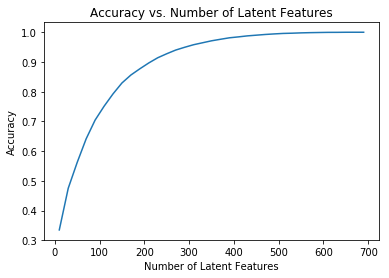

In [84]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [85]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [86]:
df_train.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [87]:
df_test.head()

,article_id,title,user_id
40000,1053.0,access mysql with python,4487
40001,1314.0,healthcare python streaming application demo,4487
40002,1424.0,use spark for python to load data and run sql ...,4487
40003,1176.0,build a python app on the streaming analytics ...,4487
40004,58.0,advancements in the spark community,4488


In [88]:
test_idx = np.array(df_test.user_id)
print(test_idx)

[4487 4487 4487 ..., 5147 5148 5149]


In [89]:
user_item_test = create_user_item_matrix(df_test)
user_item_test.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_test = create_user_item_matrix(df_test)
    user_item_train = create_user_item_matrix(df_train)
   
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [91]:
user_item_test.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
articles_null = user_item.sum()
articles_null[articles_null == 0]

Series([], dtype: float64)

In [93]:
user_in_test_but_not_in_train = list(set(test_idx)-set(list(set(user_item_train.index))))
len(user_in_test_but_not_in_train)

662

In [94]:
print('total users in test {} ; cannot predict {}'.format(len(test_idx), len(user_in_test_but_not_in_train)))

total users in test 682 ; cannot predict 662


In [95]:
art_in_test_but_not_in_train = list(set(test_arts)-set(list(set(user_item_train.columns))))
len(art_in_test_but_not_in_train)

0

In [96]:
print('total articles in test {} ; cannot predict {}'.format(len(test_arts), len(art_in_test_but_not_in_train)))

total articles in test 574 ; cannot predict 0


In [97]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [98]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# use the built in to get the three matrices
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [99]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
subset_idx = user_item_train.index.isin(test_idx)
sum(subset_idx)

20

In [100]:
u_subset = u_train[subset_idx, :]
u_subset.shape

(20, 4487)

In [101]:
subset_cols = user_item_train.columns.isin(test_arts)
sum(subset_cols)

574

In [102]:
vt_subset = vt_train[:, subset_cols]
vt_subset.shape

(714, 574)

In [103]:
subset_user_ids = list(set.intersection(set(test_idx), set(user_item_train.index)))

In [104]:
user_item_test_subset = user_item_test.loc[subset_user_ids, :]
user_item_test_subset.shape

(20, 574)

In [105]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
sum_errs_subset = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_subset_new, vt_subset_new = u_subset[:, :k], vt_subset[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_subset_est = np.around(np.dot(np.dot(u_subset_new, s_new), vt_subset_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    diffs_subset = np.subtract(user_item_test_subset, user_item_subset_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))  
    sum_errs.append(err)
    
    err_subset = np.sum(np.sum(np.abs(diffs_subset)))
    sum_errs_subset.append(err_subset)   
    


In [106]:
df.shape

(45993, 3)

In [107]:
df_train.shape

(40000, 3)

In [108]:
user_item_test.shape

(682, 574)

In [109]:
user_item_train.shape

(4487, 714)

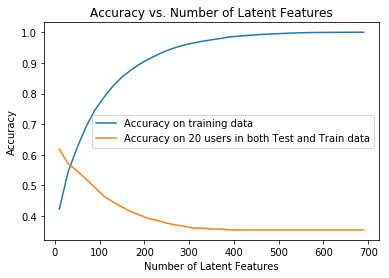

In [110]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(df.shape[0]), label='Accuracy on training data');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_subset)/user_item_test.shape[0], label='Accuracy on 20 users in both Test and Train data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
<br>The accuracy for training data is increasing with increase in N of Latent Features as expected. However, the accuracy for 10 first latent features for a subset of 20 users, existing in both Test and Train dataset, has around 65%, but with increase in number of the latent features, we add information from 662 Users, whose are new to the data and they bring no information, but noise. <br>

Another problem that our data is imbalanced, it consists only of 0's and 1's, and 0's have a much higher prevalence. Therefore, it would be more important to place "weights" on predicting correctly 1's.
In order to check what recommendation system is better: 
<br> 1. the simple one based on top rated articles
<br> 2. the one based on similarities between Users
<br> 3. the one based on latent values and based on SVD approach
We could separate all users intro 3 random groups and perform A/B tests to measure what recommendation is the best/most accurate.
In general, for this particular test/train examples, we have a very high number of New users, so we come to so called cold start problem. Therefore, it might make sense to use the simplest general approach 1.
**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [111]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0